<a href="https://colab.research.google.com/github/prarthananbhat/tsai/blob/master/S4_Assignement_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchsummary
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

In [0]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [0]:
train_example = enumerate(train_loader)
test_example = enumerate(train_loader)
train_batch_id,(train_example_data,train_example_target) = next(train_example)
test_batch_id,(test_example_data,test_example_target) = next(test_example)

Images from Train set


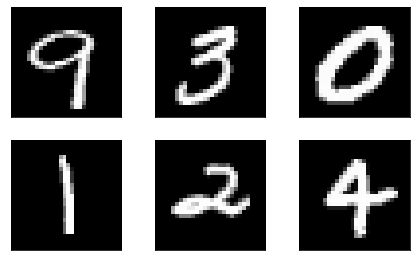

Images from Test set


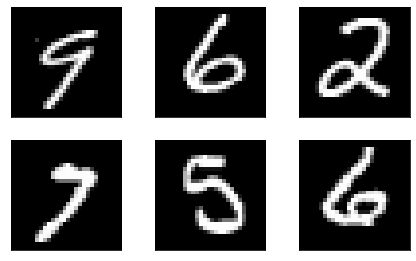

In [4]:
print("Images from Train set")

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_example_data[i][0],cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()
print("Images from Test set")

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(test_example_data[i][0],cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [0]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1 = nn.Sequential(
        # nn.Conv2d(1, 8, 3, padding=1),
        # nn.ReLU(),
        # nn.BatchNorm2d(8),
        nn.Conv2d(1, 16, 3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, 1),
        nn.Dropout(0.10)
        )
    self.conv2 = nn.Sequential(
        #nn.Conv2d(8, 16, 3, padding=1),
        #nn.ReLU(),
        #nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, stride=1, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 16, 3),
        nn.Dropout(0.10)
        )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16, 32, 3),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 10, 1),
        nn.Dropout(0.15),
        nn.AvgPool2d(3)
        )
  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)


In [12]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
         MaxPool2d-7           [-1, 32, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]             528
           Dropout-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           4,640
             ReLU-11           [-1, 32, 14, 14]               0
      BatchNorm2d-12           [-1, 32, 14, 14]              64
        MaxPool2d-13             [-1, 32, 7, 7]               0
           Conv2d-14             [-1, 1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [13]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0632, Accuracy: 9839/10000 (98.39%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9890/10000 (98.90%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9901/10000 (99.01%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9940/10000 (99.40%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99.05%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0197, Accuracy: 9942/10000 (99.42%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9934/10000 (99.34%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9929/10000 (99.29%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9932/10000 (99.32%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0179, Accuracy: 9942/10000 (99.42%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9927/10000 (99.27%)



loss=0.010745614767074585 batch_id=468: 100%|██████████| 469/469 [00:12<00:00, 38.85it/s]



Test set: Average loss: 0.0178, Accuracy: 9945/10000 (99.45%)

